In [ ]:
"""
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()
"""

'\nimport tensorflow as tf\n\ntry:\n    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])\n    tf.config.experimental_connect_to_cluster(tpu)\n    tf.tpu.experimental.initialize_tpu_system(tpu)\n    strategy = tf.distribute.experimental.TPUStrategy(tpu)\nexcept ValueError:\n    print("Not connected to a TPU runtime. Using CPU/GPU strategy")\n    strategy = tf.distribute.MirroredStrategy()\n'

In [1]:
"""
Import libraries
"""

import numpy as np
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests
import shutil

import math
from PIL import Image
from PIL import ImageFilter
from io import BytesIO

from collections import Counter
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import *
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras import Model

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip "/content/gdrive/My Drive/dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: dataset/dataset/Parasect/478f545a26ce45af8e8f08b8f5fcb830.jpg  
  inflating: __MACOSX/dataset/dataset/Parasect/._478f545a26ce45af8e8f08b8f5fcb830.jpg  
  inflating: dataset/dataset/Parasect/fe56d86c685147a78c21b1a26650aaff.jpg  
  inflating: __MACOSX/dataset/dataset/Parasect/._fe56d86c685147a78c21b1a26650aaff.jpg  
  inflating: dataset/dataset/Parasect/9ddcde80ea384223b1535afcd5676a9f.jpg  
  inflating: __MACOSX/dataset/dataset/Parasect/._9ddcde80ea384223b1535afcd5676a9f.jpg  
  inflating: dataset/dataset/Parasect/5eda0fe5659849e5b4455bd32fd3e5ed.jpg  
  inflating: __MACOSX/dataset/dataset/Parasect/._5eda0fe5659849e5b4455bd32fd3e5ed.jpg  
  inflating: dataset/dataset/Parasect/478f545a26ce45af8e8f08b8f5fcb830.jpeg  
  inflating: __MACOSX/dataset/dataset/Parasect/._478f545a26ce45af8e8f08b8f5fcb830.jpeg  
  inflating: dataset/dataset/Parasect/ec9ac3654ece4675b0dd76198f6cba74.jpg  
  inflating: __MACOSX/dataset/dataset/Parasec

Total number of categories: 149
Total number of images in dataset: 10693


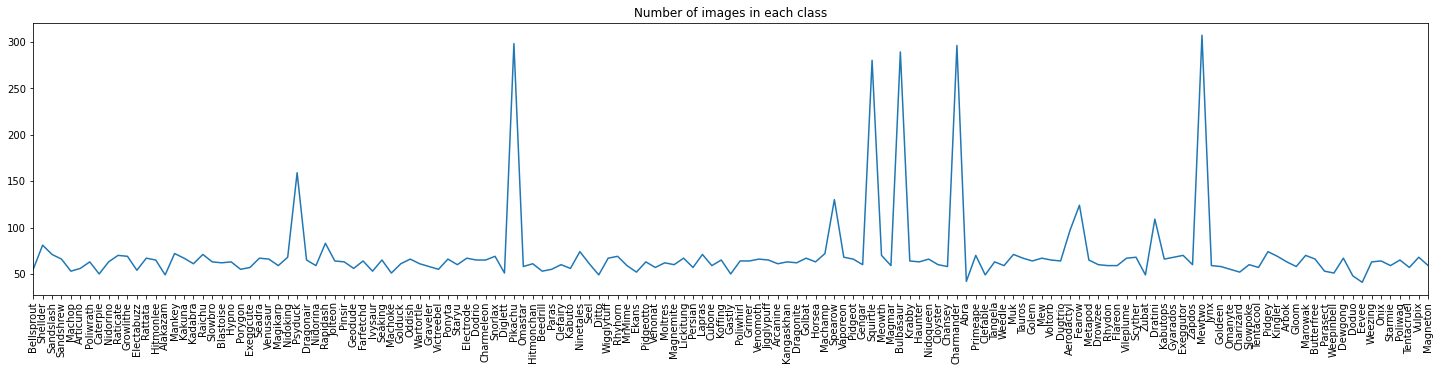

In [4]:
path = '/content/dataset' # Path to directory which contains classes
folders = os.listdir(path) # List of all classes
classes = []
for c in folders:
  if c != 'dataset':
    classes.append(c)

print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path,c)))
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [ ]:
print( pd.DataFrame.from_dict(counts.values()).describe())

                0
count  149.000000
mean    71.765101
std     43.739306
min     41.000000
25%     59.000000
50%     63.000000
75%     67.000000
max    307.000000


In [5]:
## create training images dataset directory, validation data, and test images directory
lis = ['train_images','test_images',"val_images"]
pat = '/content'
for f in lis:
    if not os.path.isdir(os.path.join(pat,f)):
        os.mkdir(os.path.join(pat,f))

In [6]:
## create pokemon folders for test, train, and validation images
for c in classes:
    pat = os.path.join('/content/train_images',c)
    if not os.path.isdir(pat):
        os.mkdir(pat)
    pat = os.path.join('/content/val_images',c)
    if not os.path.isdir(pat):
        os.mkdir(pat)
    pat = os.path.join('/content/test_images',c)
    if not os.path.isdir(pat):
        os.mkdir(pat)


In [7]:
def check_validity(filename):
  extension = str(filename[-4:])
  if extension == '.jpg' or extension == '.png' or extension == 'jpeg' or extension == '.BMP':
    return True

In [8]:
## split training, testing and validation data
train_path = os.path.join('/content','train_images')
test_path = os.path.join('/content','test_images')
val_path = os.path.join('/content','val_images')

val_ratio = 0.15
test_ratio = 0.05
for image_folder in classes:
    p = os.path.join(path,image_folder)
    pat_train = os.path.join(train_path,image_folder)
    pat_test = os.path.join(test_path,image_folder)
    pat_val = os.path.join(val_path,image_folder)
    if not os.path.join(train_path,image_folder):
        os.mkdir(os.path.join(train_path,image_folder))
    if not os.path.join(test_path,image_folder):
        os.mkdir(os.path.join(test_path,image_folder))
    # Creating partitions of the data after shuffling for randomness
    allFiles = os.listdir(p)
    np.random.shuffle(allFiles)
    trainFiles, valFiles, testFiles = np.split(np.array(allFiles),
                                              [int(len(allFiles)* (1 - (val_ratio + test_ratio))), 
                                              int(len(allFiles)* (1 - test_ratio))])
    train_images = trainFiles.tolist()
    val_images = valFiles.tolist()
    test_images = testFiles.tolist()
    ##copy images from original folders to the train, test and val folders
    for img in train_images:
        if (check_validity(img)):
            src = os.path.join(p,img)
            des = os.path.join(pat_train,img)
            shutil.copy(src,des)
    for img in val_images:
        if (check_validity(img)):
            src = os.path.join(p,img)
            des = os.path.join(pat_val,img)
            shutil.copy(src,des)
    for img in test_images:
        if (check_validity(img)):
            src = os.path.join(p,img)
            des = os.path.join(pat_test,img)
            shutil.copy(src,des)

In [9]:
##undersampling
for pokemon in classes:
  folderPath = os.path.join("/content/train_images",pokemon)
  for imagefile in os.listdir(folderPath):
    if len(os.listdir(folderPath)) <= 50:
      break
    else:
      if (check_validity(imagefile)):
        os.remove(os.path.join(folderPath,imagefile))


Total number of images in dataset: 7083


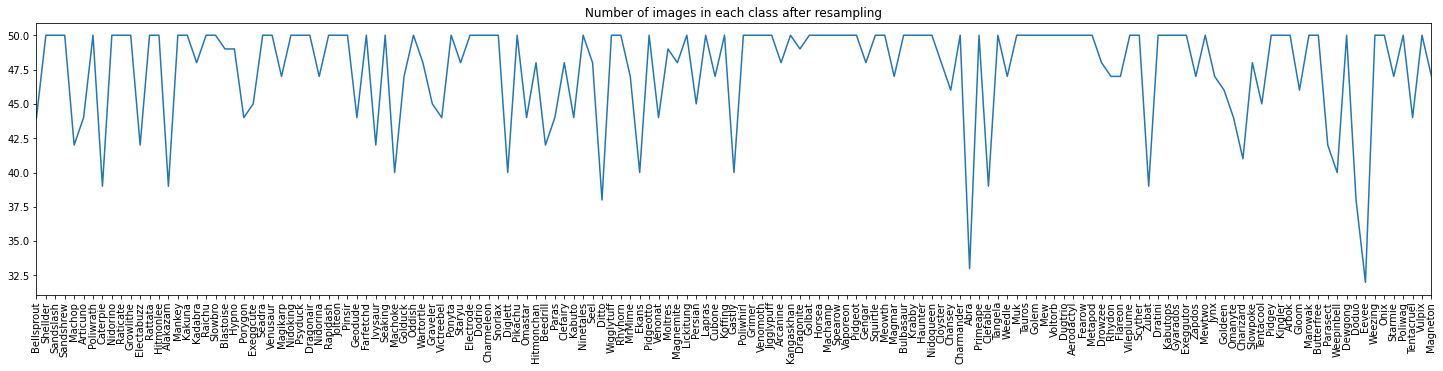

In [10]:
# A dictionary which contains class and number of images in that class
new_counts = {}
for c in classes:
    new_counts[c] = len(os.listdir(os.path.join("/content/train_images",c)))
print(f'Total number of images in dataset: {sum(list(new_counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(new_counts.keys()), y = list(new_counts.values())).set_title('Number of images in each class after resampling')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [11]:
print( pd.DataFrame.from_dict(new_counts.values()).describe())
##std gets smaller

                0
count  149.000000
mean    47.536913
std      3.762409
min     32.000000
25%     47.000000
50%     50.000000
75%     50.000000
max     50.000000


In [12]:
# Creating train, test and valid batches from the directories

datagen = ImageDataGenerator(rescale=1.0/255,
                            width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             rotation_range=45,
                             fill_mode='nearest')

train_batches = datagen.flow_from_directory(directory = train_path, 
                                    target_size = (96,96), ##resize the image, we want it to be small so it will not crash because of ram usage
                                    batch_size = 100) ##Batch size specifies how many training samples should be passed to the neural network in one go before the weights of the neural network are updated.
valid_batches = datagen.flow_from_directory(directory=val_path, 
                                            target_size=(96,96), 
                                            batch_size=100)
test_batches = datagen.flow_from_directory(directory=test_path, 
                                          target_size=(96,96), 
                                          batch_size=100, shuffle=False) ## set Shuffule=False for confusion matrix

Found 7083 images belonging to 149 classes.
Found 1578 images belonging to 149 classes.
Found 606 images belonging to 149 classes.


In [13]:
## create our own CNN architecture
model = Sequential()
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(96, 96, 3), kernel_initializer = 'he_normal'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation = 'softmax'))

##take a look of our model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        3

In [14]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist1 = model.fit(train_batches, epochs=20, validation_data=valid_batches)

Epoch 1/20
 7/71 [=>............................] - ETA: 5:54 - loss: 6.1252 - accuracy: 0.0057

In [ ]:
hist2 = model.fit(train_batches, epochs=20, validation_data=valid_batches)

In [ ]:
hist3 = model.fit(train_batches, epochs=10, validation_data=valid_batches)

In [ ]:
hist4 = model.fit(train_batches, epochs=10, validation_data=valid_batches)

In [ ]:
# Plot learning curves

fig = plt.figure(figsize = (17, 4))

plt.subplot(121)
plt.plot(hist1.history['accuracy'] + hist2.history['accuracy'] +hist3.history['accuracy'] +hist4.history['accuracy']  , label = 'acc')
plt.plot(hist1.history['val_accuracy'] +hist2.history['val_accuracy']+hist3.history['val_accuracy']+hist4.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(hist1.history['loss'] + hist2.history['loss']+ hist3.history['loss']+ hist4.history['loss'], label = 'loss')
plt.plot(hist1.history['val_loss'] + hist2.history['val_loss'] + hist3.history['val_loss']+ hist4.history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [ ]:
predictions = model.predict(test_batches)

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm)

In [ ]:
##transfer learning
rn = ResNet50(include_top=False,weights='imagenet',input_shape = (96,96,3))
layer1 = GlobalAveragePooling2D()(rn.output)
layer2 = Dense(1000,activation = 'relu')(layer1)
layer3 = Dense(500,activation='relu')(layer2)
layer_out = Dense(149,activation='softmax')(layer3)
model_new = Model(inputs=rn.input,outputs = layer_out)
model_new.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
hist = model.fit(train_generator,epochs=20,validation_data=val_generator)